In [1]:
import numpy as np
import os
import cst
import cst.interface
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

import filter
import script_helper
from field_data_retrieving_helper import find_field_data_of_interest_fsolver
from cst_modeler_helper import metal_thickness, copper_pure
from cst_modeler_helper import define_brick, define_components, mirror_objects
from data_saving_helper import generate_file, list_datasets, save_data, retrieve_dataset

In [2]:
iteration_num = 7 # Iteration number must be greater than or equal to 1
run_cst = True
f0 = 1.03e9 # Hz

y_min = [-6, -6]
y_max = [6,  6]
x_min_init = [-6.05, 4.55]
x_max_init = [-4.55, 6.05]

x_lim = [(-7.55, -4.55), (4.55, 7.55)] # (min, max)

min_track_width = 0.7

# For 3rd order poly fit at the interfaces
sample_rate = np.array([10, 10], dtype=int)
sample_distance = np.array([30, 30], dtype=int)

axis = [-1, -1] # axis = 1: x-axis optimization, otherwise y-axis optimization
priority = [-1, -1] # 1: prioritize the upper bound, otherwise the lower bound
step_size = [0.05, 0.05]

In [3]:
if iteration_num == 1: 
    coordinates = script_helper.coordinates_init([(x_min_init[0], x_max_init[0], y_min[0], y_max[0], step_size[0], axis[0]), 
                                                  (x_min_init[1], x_max_init[1], y_min[1], y_max[1], step_size[1], axis[1])])

    description = """This is dual-mode resonator/filter optimization.
                    Coordinates format for each trail: 
                        (y, x_upper_bound, x_lower_bound)
                        (y, x_upper_bound, x_lower_bound)
                    All 1D arrays in the tuple."""

    file_name = generate_file('iteration_0')
    save_data(file_name, description, coordinates)

## Set Up the CST Environment 

### Create a microwave studio project or open an existing one

In [4]:
if run_cst == True: 
    filename = f"iteration_{iteration_num}.cst"
    path = f"D:\CSTStudioFiles\DualModeResonator\iteration_{iteration_num}"
    fullname = os.path.join(path, filename)
    print(fullname)

D:\CSTStudioFiles\DualModeResonator\iteration_7\iteration_7.cst


In [5]:
if run_cst == True: 
    cst_handler = cst.interface.DesignEnvironment()

    print(f"Current time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

    if os.path.exists(fullname):
        print("File exists.")
        mws = cst_handler.open_project(fullname)
        print("Project opened successfully.")
    else:
        """
        print("File does not exist. Creating a new one.")
        mws = cst_handler.new_mws() # a Microwave Studio Project instance
        print("New MWS project created and opened successfully.")
        """
        raise FileExistsError(f"File {filename} does not exist.")

    mws.save(fullname)
    modeler = mws.modeler

Current time: 2024-11-30 17:08:36
File exists.
Project opened successfully.


## Data Post-Processing

### Retrieve E and H Data

Retrieve E and H forward and backward simulation data from the last iteration, and calculate the geometry updates.

In [6]:
file_path_last_iteration = f'coordinate_history/iteration_{iteration_num-1}.hdf5'
coordinates = retrieve_dataset(file_path_last_iteration, 'coordinates')
coordinates_flattened, coords_shape = script_helper.coordinates_flatten(coordinates, axis)

# Forward E field
file_path_e_forward = f'results/iteration_{iteration_num-1}_e_forward.h5'
e_forward_complex_values = find_field_data_of_interest_fsolver(file_path_e_forward, coordinates_flattened, 'E-Field')

# Backward E field
file_path_e_backward = f'results/iteration_{iteration_num-1}_e_backward.h5'
e_backward_complex_values = find_field_data_of_interest_fsolver(file_path_e_backward, coordinates_flattened, 'E-Field')

# Forward H field
file_path_h_forward = f'results/iteration_{iteration_num-1}_h_forward.h5'
h_forward_complex_values = find_field_data_of_interest_fsolver(file_path_h_forward, coordinates_flattened, 'H-Field')

# Backward H field
file_path_h_backward = f'results/iteration_{iteration_num-1}_h_backward.h5'
h_backward_complex_values = find_field_data_of_interest_fsolver(file_path_h_backward, coordinates_flattened, 'H-Field')

### Calculate Geometry Updates

#### Calculcate delta_p at each point

In [7]:
p_in = 1.0
omega = 2 * np.pi * f0
eps0 = 8.8541878188e-12 # F/m
mu0 = 1.25663706127e-6 # N/A2
delta_t = 1e9

delta_p = []
for idx, coord in enumerate(coordinates_flattened):
    e_forward = e_forward_complex_values[idx]
    e_backward = e_backward_complex_values[idx]
    h_forward = h_forward_complex_values[idx]
    h_backward = h_backward_complex_values[idx]

    delta_p.append(1j * (-2 * omega) / p_in * 
                   (eps0 * np.dot(e_forward, e_backward) + mu0 * np.dot(h_forward, h_backward)))

delta_p = np.array(delta_p)
delta_p_real = delta_p.real / delta_t

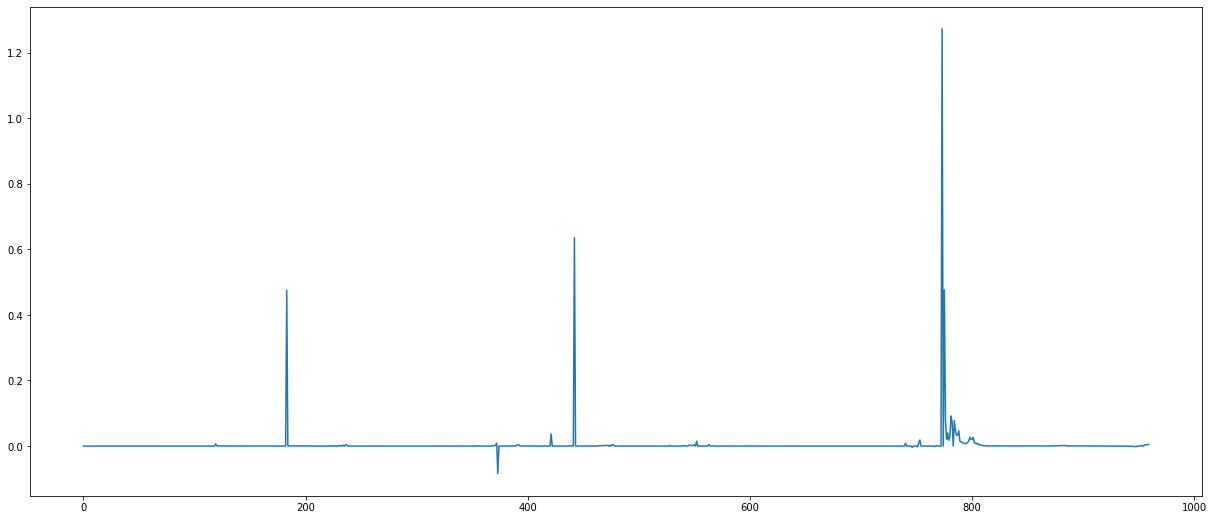

In [8]:
plt.figure(figsize=(21,9))
plt.plot(delta_p_real)
plt.show()

#### Calculate new boundaries

In [9]:
coordinates_new = coordinates_flattened.copy()
coordinates_new = [(x+delta_p_real[i], y) for i, (x, y) in enumerate(coordinates_new)]
coordinates_new = script_helper.coordinates_resemble(coordinates_new, coords_shape, axis)
y, x_upper_bound, x_lower_bound = script_helper.coordinates_distribute(coordinates_new, -1)
num_of_section, lengths = script_helper.find_coordinate_shape(coordinates_new)

y = np.array(y, dtype=float)
x_upper_bound = np.array(x_upper_bound, dtype=float)
x_lower_bound = np.array(x_lower_bound, dtype=float)

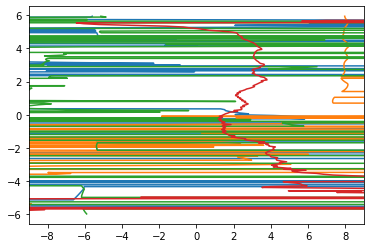

In [10]:
plt.plot(x_upper_bound[0], y[0])
plt.plot(x_upper_bound[1], y[1])
plt.plot(x_lower_bound[0], y[0])
plt.plot(x_lower_bound[1], y[1])
plt.xlim(-9, 9)
plt.show()

#### Resolve boundary conflicts

In [11]:
for i in range(num_of_section):
    for j in range(lengths[i]):
        ub = np.max([x_upper_bound[i][j], x_lower_bound[i][j]])
        lb = np.min([x_upper_bound[i][j], x_lower_bound[i][j]])
        x_upper_bound[i][j], x_lower_bound[i][j] = ub, lb

#### Smooth boundaries

In [12]:
# Smooth the upper and lower bounds of the trail
for i in range(num_of_section): 
    x_upper_bound[i][:] = np.clip(x_upper_bound[i][:], x_lim[i][0], x_lim[i][1])
    x_lower_bound[i][:] = np.clip(x_lower_bound[i][:], x_lim[i][0], x_lim[i][1])
    x_upper_bound[i][:] = filter.gaussian_filter(x_upper_bound[i][:], 5)
    x_lower_bound[i][:] = filter.gaussian_filter(x_lower_bound[i][:], 5)

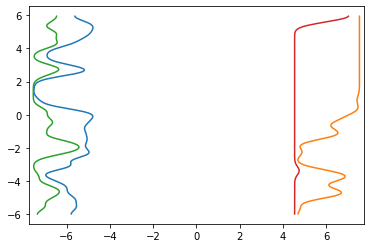

In [13]:
plt.plot(x_upper_bound[0], y[0])
plt.plot(x_upper_bound[1], y[1])
plt.plot(x_lower_bound[0], y[0])
plt.plot(x_lower_bound[1], y[1])
plt.xlim(-7.75, 7.75)
plt.show()

### Clip the boundaries

In [14]:
for i in range(num_of_section):
    x_upper_bound[i][:] = np.clip(x_upper_bound[i][:], x_lim[i][0], x_lim[i][1])
    x_lower_bound[i][:] = np.clip(x_lower_bound[i][:], x_lim[i][0], x_lim[i][1])

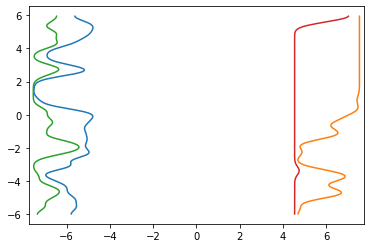

In [15]:
plt.plot(x_upper_bound[0], y[0])
plt.plot(x_upper_bound[1], y[1])
plt.plot(x_lower_bound[0], y[0])
plt.plot(x_lower_bound[1], y[1])
plt.xlim(-7.75, 7.75)
plt.show()

#### Limit track widths

Limit the track widths above the threshold.

In [16]:
for i in range(num_of_section):
    for j in range(lengths[i]):
        width = x_upper_bound[i][j] - x_lower_bound[i][j]
        width = np.max([min_track_width, width])
        if priority[i] == 1: x_lower_bound[i][j] = x_upper_bound[i][j] - width
        else: x_upper_bound[i][j] = x_lower_bound[i][j] + width

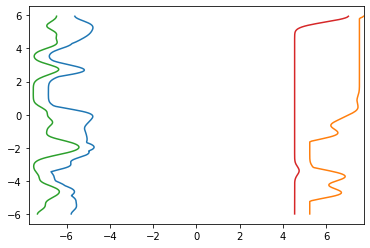

In [17]:
plt.plot(x_upper_bound[0], y[0])
plt.plot(x_upper_bound[1], y[1])
plt.plot(x_lower_bound[0], y[0])
plt.plot(x_lower_bound[1], y[1])
plt.xlim(-7.75, 7.75)
plt.show()

#### Interface optimized areas with fixed regions

Using a 3rd order polynomial fit.

In [18]:
for i in range(num_of_section):
    x_upper_bound[i] = script_helper.poly_fit_ends(x_upper_bound[i].copy(), y[i].copy(), 
                                                   (x_max_init[i], y_min[i]), (x_max_init[i], y_max[i]), step_size[i],
                                                   sample_rate[i], sample_distance[i], axis=-1)
    x_lower_bound[i] = script_helper.poly_fit_ends(x_lower_bound[i].copy(), y[i].copy(), 
                                                   (x_min_init[i], y_min[i]), (x_min_init[i], y_max[i]), step_size[i],
                                                   sample_rate[i], sample_distance[i], axis=-1)


In [19]:
for i in range(num_of_section):
    if x_lim[i][1] != None:
        x_upper_bound[i][:] = np.clip(x_upper_bound[i][:], None, x_lim[i][1])
    if x_lim[i][0] != None: 
        x_lower_bound[i][:] = np.clip(x_lower_bound[i][:], x_lim[i][0], None)

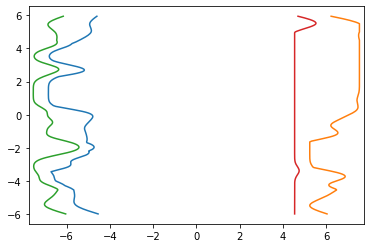

In [20]:
plt.plot(x_upper_bound[0], y[0])
plt.plot(x_upper_bound[1], y[1])
plt.plot(x_lower_bound[0], y[0])
plt.plot(x_lower_bound[1], y[1])
plt.xlim(-7.75, 7.75)
plt.show()

#### Resolve case-wise conflicts

In the double transmission line optimization case, it is necessary to prevent overlap between the upper bound of the sample line and lower bound of the main line. 

#### Save coordinate data

In [21]:
description = """This is dual-mode resonator/filter optimization.
                Coordinates format for each trail: 
                    (y, x_upper_bound, x_lower_bound)
                    (y, x_upper_bound, x_lower_bound)
                All 1D arrays in the tuple."""
file_path_coordinates = generate_file(f'iteration_{iteration_num}')
save_data(file_path_coordinates, description, coordinates_new)

## Update Geometries

### Create optimized geometries

In [22]:
if run_cst == True:
    # The number of components should match the number of sections
    component_names = ['dynamic_pattern_1', 'dynamic_pattern_2']
    define_components(modeler=modeler, component_names=component_names)

    for i in range(num_of_section):
        for j in range(lengths[i]):
            define_brick(modeler=modeler,
                        brick_name=f'delta_line_{j}', component_name=component_names[i],
                        material=copper_pure,
                        x_range=(x_lower_bound[i][j], x_upper_bound[i][j]), 
                        y_range=(y[i][j], y[i][j] + step_size[i]), 
                        z_range=(0, metal_thickness))

Mirror the optimized geometries.

In [23]:
%%script echo skip

if run_cst == True: 
    for i in range(num_of_section):
        mirror_objects(modeler, component_names[i])

Couldn't find program: 'echo'


### Run the simulation and save

In [24]:
if run_cst == True:
    modeler.run_solver()
    mws.save(fullname)